Epoch 1, Loss: 1.9354, Accuracy: 0.3662
Epoch 2, Loss: 1.6726, Accuracy: 0.4033
Epoch 3, Loss: 1.5766, Accuracy: 0.4444
Epoch 4, Loss: 1.5168, Accuracy: 0.4774
Epoch 5, Loss: 1.4736, Accuracy: 0.4766
Epoch 6, Loss: 1.4407, Accuracy: 0.4939
Epoch 7, Loss: 1.4046, Accuracy: 0.5098
Epoch 8, Loss: 1.3787, Accuracy: 0.5182
Epoch 9, Loss: 1.3480, Accuracy: 0.5289
Epoch 10, Loss: 1.3332, Accuracy: 0.5198


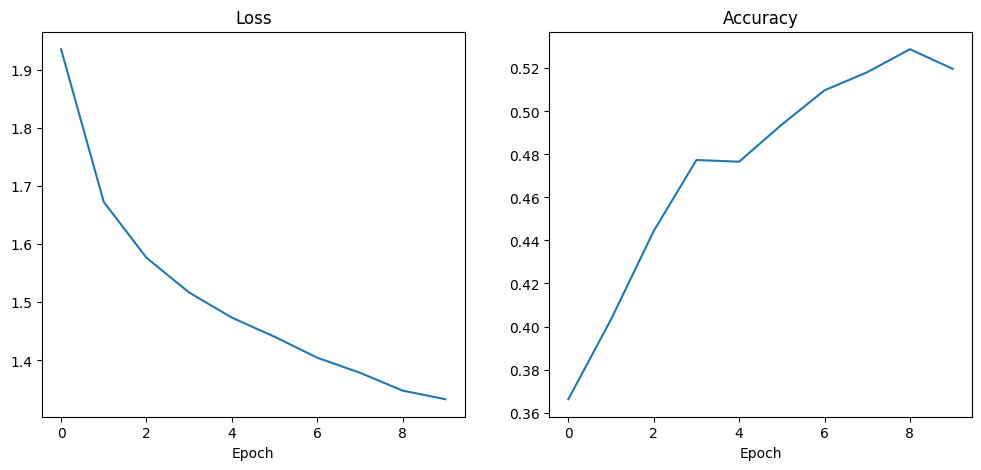

In [11]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from einops import rearrange

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TransformerModelWithAttention(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=2, num_layers=1, hidden_dim=64, dropout=0.1, seq_len=16):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_len, hidden_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, num_classes)
        self.attention_weights = []

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)
        x = x + self.positional_encoding[:, :seq_len, :]

        self.attention_weights = []

        for layer in self.transformer_encoder.layers:
            attn_output, attn_weights = layer.self_attn(x, x, x, need_weights=True)
            self.attention_weights.append(attn_weights.detach())
            x = layer(x)
        x = x.mean(dim=1)
        return self.fc_out(x)


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            b, c, h, w = imgs.shape
            patch_size = 8
            x = rearrange(imgs, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
            output = model(x)
            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return correct / total

losses = []
accuracies = []

def train_with_logging(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            b, c, h, w = imgs.shape
            patch_size = 8
            x = rearrange(imgs, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)

            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        acc = evaluate(model, test_loader)
        accuracies.append(acc)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")

input_dim = 8*8*3
num_classes = 10
seq_len = (32//8)*(32//8)
model = TransformerModelWithAttention(input_dim, num_classes, hidden_dim=128,
    num_heads=4,
    num_layers=2, seq_len=seq_len).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_with_logging(model, train_loader, test_loader, optimizer, criterion)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses, label='Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.subplot(1,2,2)
plt.plot(accuracies, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()


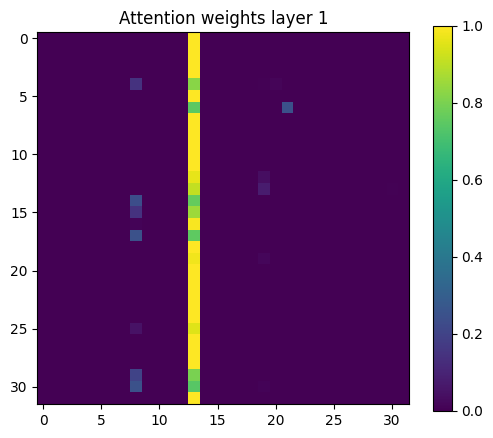

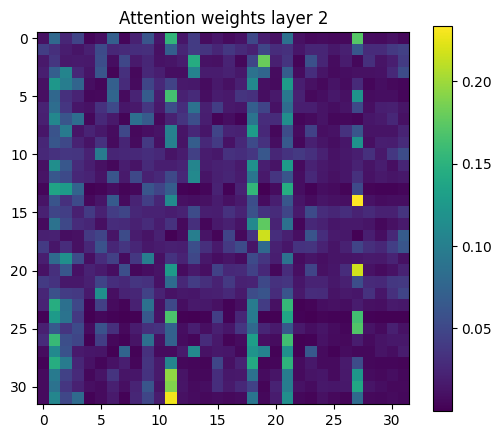

In [12]:
model.eval()
with torch.no_grad():
    imgs, labels = next(iter(test_loader))
    imgs = imgs.to(DEVICE)
    b, c, h, w = imgs.shape
    patch_size = 8
    x = rearrange(imgs, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
    _ = model(x)

num_layers_to_plot = min(5, len(model.attention_weights))
for i in range(num_layers_to_plot):
    plt.figure(figsize=(6,5))
    plt.imshow(model.attention_weights[i][0].cpu(), cmap='viridis')
    plt.title(f'Attention weights layer {i+1}')
    plt.colorbar()
    plt.show()


#Вывод  
Модель относительно неплохо научилась отличать наблюдения из CIFAR10. Вероятно, ей не хватает эпох и, возможно, hidden dims.